In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
#load data
with open("/home/vrlab/Documents/HS/Hearthstone_Winrate/dataset/hsreply_data/decks.json", 'r') as f:
    decks_ori = json.load(f)

winrate = []
decks = []
cards = set()

for deck in decks_ori:
    tmp = []
    for card in deck['deck_list']:
        for i in range(card[1]):
            tmp.append(card[0])
    if len(tmp) == 30:
        decks.append(tmp)
        for card in tmp:
            cards.add(card)
        winrate.append(deck['win_rate']/100)

cards = list(cards)

print('cards num:', len(cards))
print('decks num:', len(decks))
print('deck example:', decks[0])
print(winrate[0])

cards num: 958
decks num: 736
deck example: [99957, 99957, 97467, 97467, 100595, 100595, 97406, 97683, 98283, 98283, 98285, 98762, 98762, 97282, 97282, 85154, 85154, 79780, 97528, 97528, 98768, 98768, 86626, 80647, 80647, 101375, 97269, 97269, 97394, 97394]
0.7648


In [3]:
# one hot encode
mapping = np.eye(len(cards))
print(cards)
cards = {cards[i]:mapping[i] for i in range(len(cards))}

decks = [[cards[card] for card in deck] for deck in decks]

decks = np.array(decks)
print(decks.shape)

[69632, 69635, 69636, 69637, 100358, 69638, 71688, 100361, 100362, 100363, 71690, 100365, 71694, 100367, 69643, 100369, 69649, 94225, 69654, 69655, 98328, 71705, 69658, 69660, 69663, 71712, 69665, 84003, 69668, 69667, 84007, 98344, 81961, 94248, 81963, 94251, 69674, 73774, 69683, 81972, 81973, 69684, 69688, 69689, 69691, 79932, 96077, 92222, 92225, 69698, 69700, 92228, 69702, 69703, 92232, 69705, 69706, 92235, 69707, 98377, 98382, 92237, 86092, 69713, 92240, 69718, 69721, 92250, 92249, 75866, 75868, 86109, 86111, 92256, 86112, 69625, 98403, 69731, 71781, 69734, 69735, 86120, 75881, 92266, 98411, 69740, 92268, 69742, 92267, 98417, 98123, 69629, 86132, 69630, 98427, 98434, 86150, 80014, 82067, 80021, 96909, 82072, 82073, 84292, 71841, 84132, 98469, 96422, 92325, 82088, 69640, 92332, 94381, 86190, 92335, 69641, 73906, 92338, 92340, 100537, 100539, 100540, 86209, 100546, 82116, 100553, 102212, 80083, 80085, 98520, 80089, 80090, 86235, 80091, 73721, 102214, 102215, 71917, 102218, 84206, 719

In [4]:
# Dataloader
inputs = torch.tensor(decks, dtype=torch.float).to('cuda')
gts = torch.tensor(winrate, dtype=torch.float).to('cuda')

train_dataset = TensorDataset(inputs, gts)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [5]:
from net import Transformer

In [6]:
input_size = len(cards)
hidden_size = 1024
output_size = 1
model = Transformer(input_size, input_size, input_size, 512).to('cuda:0')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [7]:
num_epochs = 1000
losses = []
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    # 前向传播
    for input, gt in train_loader:
        # 前向传播
        outputs = model(input)
        loss = criterion(outputs, gt.view(-1, 1))

        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        optimizer.zero_grad()
        # scheduler.step()
        running_loss += loss.item()
    
    losses.append(running_loss)

    # plt.plot(losses, marker='o')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Loss Change Over Epochs')
    plt.show()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.5f}')
        with torch.no_grad():
            idxs = random.choices(range(len(inputs)), k=2)
            test_outputs = model(inputs[idxs])
            for i in range(2):
                print(f'pred: {test_outputs[i]}, gt: {gts[idxs[i]]}')


torch.save(model.state_dict(), 'model_weights.pth')



  5%|▌         | 50/1000 [00:16<05:14,  3.02it/s]

Epoch [50/1000], Loss: 0.71617
pred: tensor([0.6249], device='cuda:0'), gt: 0.7821999788284302
pred: tensor([0.6056], device='cuda:0'), gt: 0.6607999801635742


 10%|█         | 100/1000 [00:36<07:11,  2.09it/s]

Epoch [100/1000], Loss: 0.53350
pred: tensor([0.6199], device='cuda:0'), gt: 0.6811000108718872
pred: tensor([0.5352], device='cuda:0'), gt: 0.5559999942779541


 15%|█▌        | 150/1000 [01:00<06:47,  2.09it/s]

Epoch [150/1000], Loss: 0.41477
pred: tensor([0.6108], device='cuda:0'), gt: 0.5763999819755554
pred: tensor([0.5056], device='cuda:0'), gt: 0.3531999886035919


 20%|██        | 200/1000 [01:20<04:19,  3.09it/s]

Epoch [200/1000], Loss: 0.34694
pred: tensor([0.6196], device='cuda:0'), gt: 0.5960999727249146
pred: tensor([0.5940], device='cuda:0'), gt: 0.6100000143051147


 25%|██▌       | 250/1000 [01:37<04:02,  3.09it/s]

Epoch [250/1000], Loss: 0.28815
pred: tensor([0.5977], device='cuda:0'), gt: 0.6003999710083008
pred: tensor([0.6065], device='cuda:0'), gt: 0.5956000089645386


 30%|███       | 300/1000 [01:54<05:32,  2.11it/s]

Epoch [300/1000], Loss: 0.24335
pred: tensor([0.6192], device='cuda:0'), gt: 0.6078000068664551
pred: tensor([0.6087], device='cuda:0'), gt: 0.6151999831199646


 35%|███▌      | 350/1000 [02:18<05:11,  2.09it/s]

Epoch [350/1000], Loss: 0.20614
pred: tensor([0.7581], device='cuda:0'), gt: 0.765999972820282
pred: tensor([0.5918], device='cuda:0'), gt: 0.5809000134468079


 40%|████      | 400/1000 [02:42<04:47,  2.09it/s]

Epoch [400/1000], Loss: 0.17754
pred: tensor([0.5986], device='cuda:0'), gt: 0.5932000279426575
pred: tensor([0.6506], device='cuda:0'), gt: 0.6726999878883362


 45%|████▌     | 450/1000 [03:06<04:23,  2.09it/s]

Epoch [450/1000], Loss: 0.15688
pred: tensor([0.6176], device='cuda:0'), gt: 0.5989999771118164
pred: tensor([0.5940], device='cuda:0'), gt: 0.6118999719619751


 50%|█████     | 500/1000 [03:30<03:59,  2.09it/s]

Epoch [500/1000], Loss: 0.13794
pred: tensor([0.6627], device='cuda:0'), gt: 0.6773999929428101
pred: tensor([0.5484], device='cuda:0'), gt: 0.5379999876022339


 55%|█████▌    | 550/1000 [03:49<02:25,  3.09it/s]

Epoch [550/1000], Loss: 0.12248
pred: tensor([0.6703], device='cuda:0'), gt: 0.6622999906539917
pred: tensor([0.5545], device='cuda:0'), gt: 0.5473999977111816


 60%|██████    | 600/1000 [04:05<02:09,  3.09it/s]

Epoch [600/1000], Loss: 0.11015
pred: tensor([0.6027], device='cuda:0'), gt: 0.6093999743461609
pred: tensor([0.6290], device='cuda:0'), gt: 0.6370000243186951


 65%|██████▌   | 650/1000 [04:21<01:53,  3.09it/s]

Epoch [650/1000], Loss: 0.09722
pred: tensor([0.5802], device='cuda:0'), gt: 0.5688999891281128
pred: tensor([0.4260], device='cuda:0'), gt: 0.3799000084400177


 70%|███████   | 700/1000 [04:38<01:37,  3.09it/s]

Epoch [700/1000], Loss: 0.08749
pred: tensor([0.6187], device='cuda:0'), gt: 0.58160001039505
pred: tensor([0.6345], device='cuda:0'), gt: 0.620199978351593


 75%|███████▌  | 750/1000 [04:54<01:20,  3.09it/s]

Epoch [750/1000], Loss: 0.07918
pred: tensor([0.6441], device='cuda:0'), gt: 0.65829998254776
pred: tensor([0.6265], device='cuda:0'), gt: 0.6406999826431274


 80%|████████  | 800/1000 [05:16<01:35,  2.09it/s]

Epoch [800/1000], Loss: 0.07299
pred: tensor([0.5176], device='cuda:0'), gt: 0.5123000144958496
pred: tensor([0.6614], device='cuda:0'), gt: 0.6502000093460083


 85%|████████▌ | 850/1000 [05:40<01:11,  2.09it/s]

Epoch [850/1000], Loss: 0.06867
pred: tensor([0.6570], device='cuda:0'), gt: 0.6883000135421753
pred: tensor([0.6463], device='cuda:0'), gt: 0.661300003528595


 90%|█████████ | 900/1000 [06:04<00:47,  2.09it/s]

Epoch [900/1000], Loss: 0.06082
pred: tensor([0.5364], device='cuda:0'), gt: 0.5350000262260437
pred: tensor([0.4878], device='cuda:0'), gt: 0.4742000102996826


 95%|█████████▌| 950/1000 [06:28<00:23,  2.09it/s]

Epoch [950/1000], Loss: 0.05884
pred: tensor([0.5172], device='cuda:0'), gt: 0.5134999752044678
pred: tensor([0.5987], device='cuda:0'), gt: 0.59170001745224


100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]

Epoch [1000/1000], Loss: 0.05345
pred: tensor([0.6282], device='cuda:0'), gt: 0.6326000094413757
pred: tensor([0.5824], device='cuda:0'), gt: 0.5898000001907349


In [11]:
with torch.no_grad():
    inputs = inputs
    test_outputs = model(inputs)
    print(test_outputs.shape)
    for i in range(len(test_outputs)):
        print(f"pred: {test_outputs[i]} gt: {gts[i]}")

    mse = criterion(test_outputs, gts)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

torch.Size([736, 1])
pred: tensor([0.7183], device='cuda:0') gt: 0.7648000121116638
pred: tensor([0.7241], device='cuda:0') gt: 0.7613000273704529
pred: tensor([0.6887], device='cuda:0') gt: 0.7329999804496765
pred: tensor([0.7008], device='cuda:0') gt: 0.7210000157356262
pred: tensor([0.6358], device='cuda:0') gt: 0.6894999742507935
pred: tensor([0.6771], device='cuda:0') gt: 0.6823999881744385
pred: tensor([0.6611], device='cuda:0') gt: 0.6811000108718872
pred: tensor([0.6611], device='cuda:0') gt: 0.675599992275238
pred: tensor([0.6837], device='cuda:0') gt: 0.6744999885559082
pred: tensor([0.6660], device='cuda:0') gt: 0.6722000241279602
pred: tensor([0.6672], device='cuda:0') gt: 0.6699000000953674
pred: tensor([0.6556], device='cuda:0') gt: 0.6669999957084656
pred: tensor([0.6528], device='cuda:0') gt: 0.6654000282287598
pred: tensor([0.6403], device='cuda:0') gt: 0.6599000096321106
pred: tensor([0.6521], device='cuda:0') gt: 0.6546000242233276
pred: tensor([0.6363], device='cuda

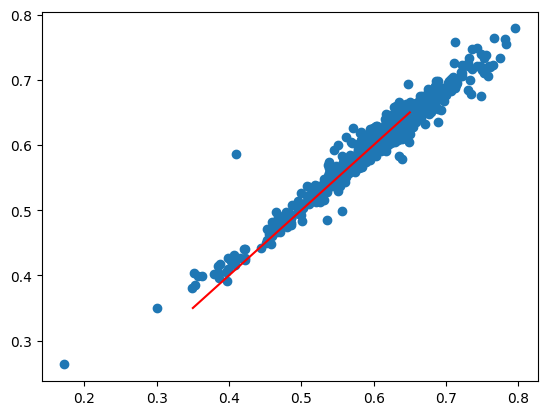

array([[1.        , 0.95190071],
       [0.95190071, 1.        ]])

In [9]:
plt.scatter(winrate,test_outputs.cpu())
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(winrate,test_outputs.view(-1).cpu())**2

In [10]:
avg_winrate = sum(winrate)/ len(winrate)
print(avg_winrate)

0.6013101902173915
